In [1]:
import pandas as pd
import numpy as np
import pickle
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score,recall_score, f1_score, roc_curve, auc, fbeta_score, make_scorer, precision_recall_curve
from sklearn.dummy import DummyClassifier

from metric_output_functions import predict_and_get_metrics, get_winner

/Users/DavidHenderson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [22]:
# Get data from prepped csv outputted near end of data_exploration.ipynb
prepped_df = pd.read_csv('./datasets/fully_prepped.csv')

#Create dataframe of input values, dataframe of output values
X_features = prepped_df.drop('over_50k', axis=1)
y_output = prepped_df['over_50k']
rand_state = 48

#Split dataframe into train, val, test sets in 60-20-20 ratio. 
#Split 60/40 into training and combined test+val set 
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X_features, y_output, test_size=0.4, random_state=rand_state)

#Split test/val 50/50 into training and validation 
X_val, X_test, y_val, y_test = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=rand_state)

#Create blank logistic regression output object list, blank random forest list, blank master list
master_lr_outputs = []
master_rf_outputs = []
master_outputs = []


# Dummy model

In [23]:
# Create dummy classifier that always predicts 1
always_under_50k = DummyClassifier(strategy='constant', constant=0)
always_under_50k.fit(X_train, y_train)

# Get output and append to logistic regression outputs list as well as master outputs list.
always_under_out = predict_and_get_metrics('Always Under', always_under_50k, X_train, X_val, y_train, y_val)
master_lr_outputs.append(always_under_out)

always_under_out.metrics_df

/Users/DavidHenderson/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DavidHenderson/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DavidHenderson/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DavidHenderson/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Train Set,Validation Set
Metric,,
Accuracy,0.760976,0.762403
AUROC,0.500000,0.500000
Precision,0.000000,0.000000
Recall,0.000000,0.000000
F beta,0.000000,0.000000


# Logistic Regression Model

### Base model

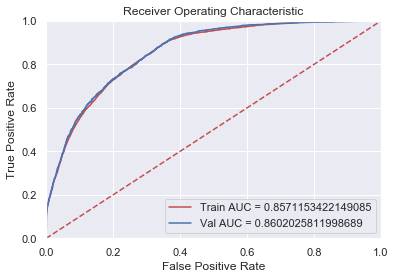

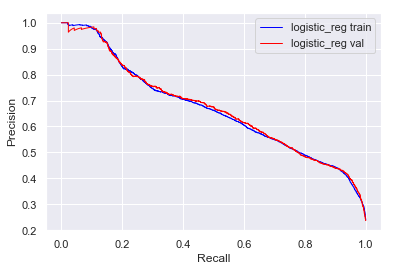

,Train Set,Validation Set
Metric,,
Accuracy,0.819707,0.822263
AUROC,0.857115,0.860203
Precision,0.668894,0.662584
Recall,0.486564,0.513374
F beta,0.583557,0.595087


In [8]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

# Predict test and validation output using this model, and create object with result metrics.
# See predict_and_get_metrics class
logout = predict_and_get_metrics('logistic_reg', logreg, X_train, X_val, y_train, y_val)
master_lr_outputs.append(logout)
logout.show_out()

### Optimize with grid search


In [ ]:
# Create lists of values to try for each parameter. 
# Experiment with different solvers, and regularization strenghts (c=inverse of reg strength).
# Increase max iterations from 100 to 500.
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
C = [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0]
max_iter = [500]

grid_params_dict = {'solver':solver, 
                 'C':C, 'max_iter':max_iter}

# Create custom scorer (metric to optimize by): fbeta score with beta = 0.8. Favors precision over recall slightly.
fbeta_scorer = make_scorer(fbeta_score, beta=0.8)

# Attempt every possible combination in above parameter dictionary, use 4-fold cross validation.
log_reg_grid = LogisticRegression()
log_reg_grid = GridSearchCV(estimator = log_reg_grid, scoring=fbeta_scorer, param_grid = grid_params_dict, 
                            cv = 4, n_jobs=-1)
log_reg_grid.fit(X_train, y_train)

# Print best parameters from randomized grid search
# Last output {'C': 2.0, 'max_iter': 500, 'solver': 'newton-cg'}
print(f"Best parameter set: {log_reg_grid.best_params_}")

# Store best model from randomized parameter search in memory, and pickle for future use.
log_reg_grid_model = log_reg_grid.best_estimator_
pickle.dump(log_reg_grid_model, open( "./pickledmodels/log_reg_grid_model.pkl", "wb" ))


In [9]:
# Run this cell to use pickled version of model
log_reg_grid_model = pickle.load(open( "./pickledmodels/log_reg_grid_model.pkl", "rb" ))

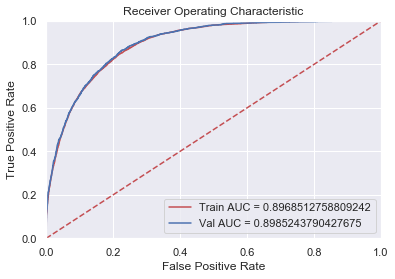

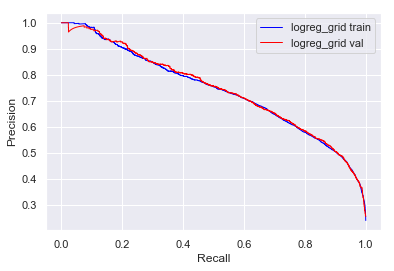

,Train Set,Validation Set
Metric,,
Accuracy,0.845775,0.846863
AUROC,0.896851,0.898524
Precision,0.719413,0.712152
Recall,0.581618,0.596635
F beta,0.658529,0.662124


In [10]:
log_reg_grid_out = predict_and_get_metrics('logreg_grid', log_reg_grid_model, X_train, X_val, y_train, y_val)
master_lr_outputs.append(log_reg_grid_out)
log_reg_grid_out.show_out()  

### Compare logistic regression methods

In [11]:
get_winner(master_lr_outputs)

Highest accuracy (0.8468634686346863) and highest fbeta score (0.6621242906186506) achieved by logreg_grid:


,Train Set,Validation Set
Metric,,
Accuracy,0.845775,0.846863
AUROC,0.896851,0.898524
Precision,0.719413,0.712152
Recall,0.581618,0.596635
F beta,0.658529,0.662124


In [12]:
master_outputs.append(log_reg_grid_out)

# Random Forest Model

### Base Model

In [233]:
# Create random forest estimator with default parameters, gini criterion, 100 estimators.
r_forest_default = RandomForestClassifier(criterion="gini", n_estimators = 100)
r_forest_default.fit(X_train, y_train)
pickle.dump(r_forest_default, open( "./pickledmodels/r_forest_default.pkl", "wb" ))

In [13]:
# Run block to use pickled representation of model
r_forest_default = pickle.load(open("./pickledmodels/r_forest_default.pkl", "rb"))

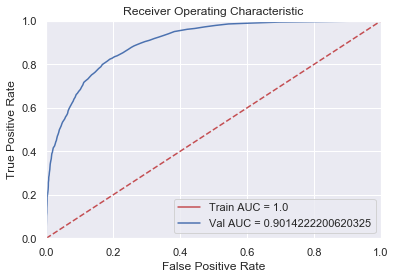

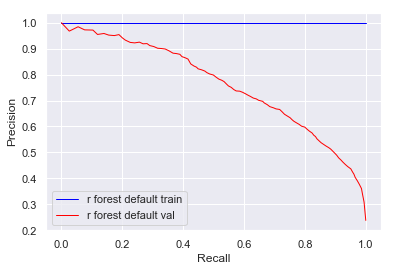

,Train Set,Validation Set
Metric,,
Accuracy,0.999966,0.851579
AUROC,1.000000,0.901422
Precision,1.000000,0.720588
Recall,0.999857,0.613028
F beta,0.999944,0.674411


In [14]:
#Store and display output
r_forest_out = predict_and_get_metrics('r forest default', r_forest_default, X_train, X_val, y_train, y_val)
master_rf_outputs.append(r_forest_out)
r_forest_out.show_out()

### Optimize with randomized search

In [236]:
# Create lists of potential values for each parameter that will be randomized.
n_estimators = list(range(0, 200))
max_depth = list(range(20,150))
max_depth.append(None)
bootstrap = ['True', 'False']
max_features = list(range(1,len(X_train.columns)))

# Create dictionary of parameter options.
rand_params_dict = {'n_estimators':n_estimators, 
                 'max_depth':max_depth, 
                 'bootstrap':bootstrap, 
                 'max_features':max_features}

# Use randomized search with 75 iterations and 4 cross validation folds
r_forest_rand = RandomForestClassifier()
r_forest_rand = RandomizedSearchCV(estimator = r_forest_rand, scoring=fbeta_scorer, param_distributions = rand_params_dict, 
                               n_iter =75, cv = 4, random_state=rand_state, n_jobs=-1)
r_forest_rand.fit(X_train, y_train)

# Print best parameters from randomized parameter search. 
#Last output {'n_estimators': 116, 'max_features': 17, 'max_depth': 23, 'bootstrap': 'True'}
print(f"Best parameter set: {r_forest_rand.best_params_}")

# Pickle best model from search for future use.
rf_rand_model = r_forest_rand.best_estimator_
pickle.dump(rf_rand_model, open( "./pickledmodels/rf_rand_model.pkl", "wb" ))

Best parameter set: {'n_estimators': 116, 'max_features': 17, 'max_depth': 23, 'bootstrap': 'True'}


In [15]:
# Run this cell to use pickled representation of model. 
rf_rand_model = pickle.load(open("./pickledmodels/rf_rand_model.pkl", "rb"))

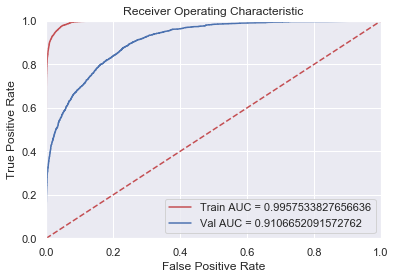

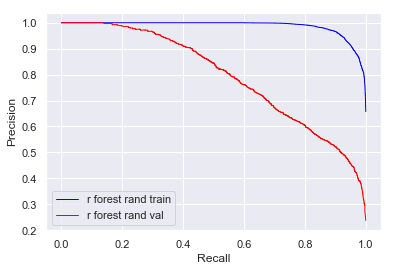

,Train Set,Validation Set
Metric,,
Accuracy,0.965527,0.860496
AUROC,0.995753,0.910665
Precision,0.972683,0.759350
Recall,0.880503,0.604400
F beta,0.934504,0.690289


In [16]:
# Get metrics/output for best random model's performance on training and validation set. Store.
rf_rand_out = predict_and_get_metrics('r forest rand', rf_rand_model, X_train, X_val, y_train, y_val)
master_rf_outputs.append(r_forest_out)
rf_rand_out.show_out()

### Fine tune with grid search


In [242]:
# Create lists of values to try for each parameter based on best random output.
n_estimators = [100, 120, 140, 199]
max_depth = [15,20,25]
bootstrap = ['False']
max_features = [15,20,25]

grid_params_dict = {'n_estimators':n_estimators, 
                 'max_depth':max_depth, 
                 'bootstrap':bootstrap, 
                 'max_features':max_features}

r_forest_grid = RandomForestClassifier()

# Attempt every possible combination in above parameter dictionary, using 4-fold cross validation.
r_forest_grid = GridSearchCV(estimator = r_forest_grid, scoring=fbeta_scorer, param_grid = grid_params_dict, 
                                cv = 4, n_jobs=-1)
r_forest_grid.fit(X_train, y_train)

# Print best parameters from randomized grid search
# Last output {'bootstrap': 'False', 'max_depth': 20, 'max_features': 15, 'n_estimators': 100}

print(f"Best parameter set: {r_forest_grid.best_params_}")

# Store best model from randomized parameter search in memory, and pickle for future use.
rf_grid_model = r_forest_grid.best_estimator_
pickle.dump(rf_grid_model, open( "./pickledmodels/rf_grid_model.pkl", "wb" ))

Best parameter set: {'bootstrap': 'False', 'max_depth': 20, 'max_features': 15, 'n_estimators': 100}


In [17]:
# Run cell to use pickled model. 
rf_grid_model = pickle.load(open( "./pickledmodels/rf_grid_model.pkl", "rb" ))

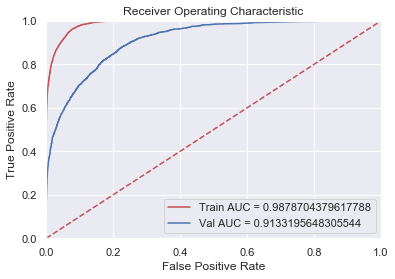

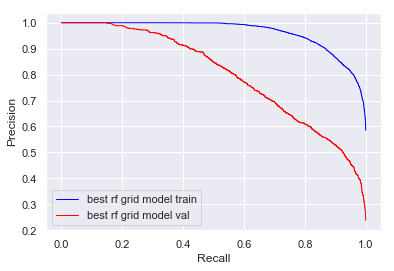

,Train Set,Validation Set
Metric,,
Accuracy,0.941064,0.863059
AUROC,0.987870,0.913320
Precision,0.940204,0.768600
Recall,0.804603,0.606126
F beta,0.882184,0.695813


In [18]:
# Get metrics/output for best model's performance on training and validation set. 
rf_grid_out = predict_and_get_metrics('best rf grid model', rf_grid_model, X_train, X_val, y_train, y_val)
master_rf_outputs.append(rf_grid_out)
rf_grid_out.show_out()

### Compare random forest models

In [19]:
get_winner(master_rf_outputs)

Highest accuracy (0.8630586305863058) and highest fbeta score (0.6958134029086342) achieved by best rf grid model:


,Train Set,Validation Set
Metric,,
Accuracy,0.941064,0.863059
AUROC,0.987870,0.913320
Precision,0.940204,0.768600
Recall,0.804603,0.606126
F beta,0.882184,0.695813


In [20]:
master_outputs.append(rf_grid_out)

# Choose Best Overall Model

In [21]:
get_winner(master_outputs)

Highest accuracy (0.8630586305863058) and highest fbeta score (0.6958134029086342) achieved by best rf grid model:


,Train Set,Validation Set
Metric,,
Accuracy,0.941064,0.863059
AUROC,0.987870,0.913320
Precision,0.940204,0.768600
Recall,0.804603,0.606126
F beta,0.882184,0.695813
